In [31]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [32]:
data = pd.read_csv('/content/drive/MyDrive/housing.csv')
X = data.drop('MEDV', axis=1)
y = data['MEDV']
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [33]:
test_size = 0.21
random_state = 49
scale = StandardScaler()

Функция обучения модели линейно регрессии

In [34]:
def skl_model(X_train, y_train, X_test, y_test):
  model = LinearRegression(fit_intercept=True)
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  mae_train = mean_absolute_error(y_train, y_train_pred)

  y_test_pred = model.predict(X_test)
  mae_test = mean_absolute_error(y_test, y_test_pred)

  return y_train_pred, y_test_pred, mae_train, mae_test

Функция для аналитического метода

In [35]:
def hand(X_train, y_train, X_test, y_test):
  XTX = X_train.T @ X_train
  cond_number = np.linalg.cond(XTX)

  try:
      theta = np.linalg.inv(XTX) @ X_train.T @ y_train
  except np.linalg.LinAlgError:
      theta = np.linalg.pinv(XTX) @ X_train.T @ y_train

  train_pred = X_train @ theta
  test_pred = X_test @ theta

  mae_train = mean_absolute_error(y_train, train_pred)
  mae_test = mean_absolute_error(y_test, test_pred)

  return train_pred, test_pred, mae_train, mae_test, cond_number

In [36]:
def report(degree, interact=True, all=False, by_hand=False, draw=False):
  # Создаём датафрейм для таблицы
  res = pd.DataFrame(columns=['Scaler', 'Degree', 'MAE Train', 'MAE Test', 'Condition Number'])

  # Ицициализируем переменные
  cond_num = 0
  start = 0 if all else degree - 1
  end = degree

  figure(figsize=(20, 9 * end))

  for i in range(start, end):

    # Полиномиализируем признаки
    poly = PolynomialFeatures(i + 1, include_bias=True, interaction_only=interact)

    # Делим данные на тестовые и обучающие
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_test = poly.fit_transform(X_train), poly.transform(X_test)

    if not by_hand:
      pred_train, pred_test, mae_train, mae_test = skl_model(X_train, y_train, X_test, y_test)
    else:
      pred_train, pred_test, mae_train, mae_test, cond_num = hand(X_train, y_train, X_test, y_test)

    # Запись в таблицу
    res.loc[len(res)] = {
        "Scaler": False,
        "Degree": i + 1,
        "MAE Train": round(mae_train, 3),
        "MAE Test": round(mae_test, 3),
        "Condition Number": cond_num
    }


    # Отрисовка графиков

    # Скелер False
    if draw:
      plt.subplot(degree, 2, i * 2 + 1)
      plt.scatter(y_train, pred_train, alpha=0.7)
      plt.scatter(y_test, pred_test, alpha=0.7)
      plt.plot(y_train, y_train, color="red")
      plt.xlabel("Real Values")
      plt.ylabel("Predicted Values")
      plt.title(f"Way: {'By matrix' if by_hand else 'By sklearn LR'} \n Polynom Degree: {i + 1}, Scaler: False, Interaction: {interact} \n MAE (Train) = {mae_train}, MAE (Test) = {mae_test}")

    # Скелер True
    if not by_hand:
      X_train, X_test = scale.fit_transform(X_train), scale.transform(X_test)
      pred_train, pred_test, mae_train, mae_test = skl_model(X_train, y_train, X_test, y_test)
    else:
      x_scaler = StandardScaler()
      X_train = x_scaler.fit_transform(X_train)
      X_test = x_scaler.transform(X_test)

      y_scaler = StandardScaler()
      y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

      pred_train, pred_test, z, b, k = hand(X_train, y_train, X_test, y_test)
      pred_train = y_scaler.inverse_transform(pred_train.reshape(-1, 1)).flatten()
      pred_test = y_scaler.inverse_transform(pred_test.reshape(-1, 1)).flatten()
      y_train = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

      # Расчет ошибок
      mae_train = mean_absolute_error(y_train, pred_train)
      mae_test = mean_absolute_error(y_test, pred_test)

    # Запись в таблицу
    res.loc[len(res)] = {
        "Scaler": True,
        "Degree": i + 1,
        "MAE Train": round(mae_train, 3),
        "MAE Test": round(mae_test, 3),
        "Condition Number": cond_num
    }

    if draw:
      plt.subplot(degree, 2, i * 2 + 2)
      plt.scatter(y_train, pred_train, alpha=0.7)
      plt.scatter(y_test, pred_test, alpha=0.7)
      plt.plot(y_train, y_train, color="red")
      plt.xlabel("Real Values")
      plt.ylabel("Predicted Values")
      plt.title(f"Way: {'By matrix' if by_hand else 'By sklearn LR'} \n Polynom Degree: {i + 1}, Scaler: True, Interaction: {interact} \n MAE (Train) = {mae_train}, MAE (Test) = {mae_test}")

  if not by_hand:
    res = res.drop('Condition Number', axis=1)

  return res


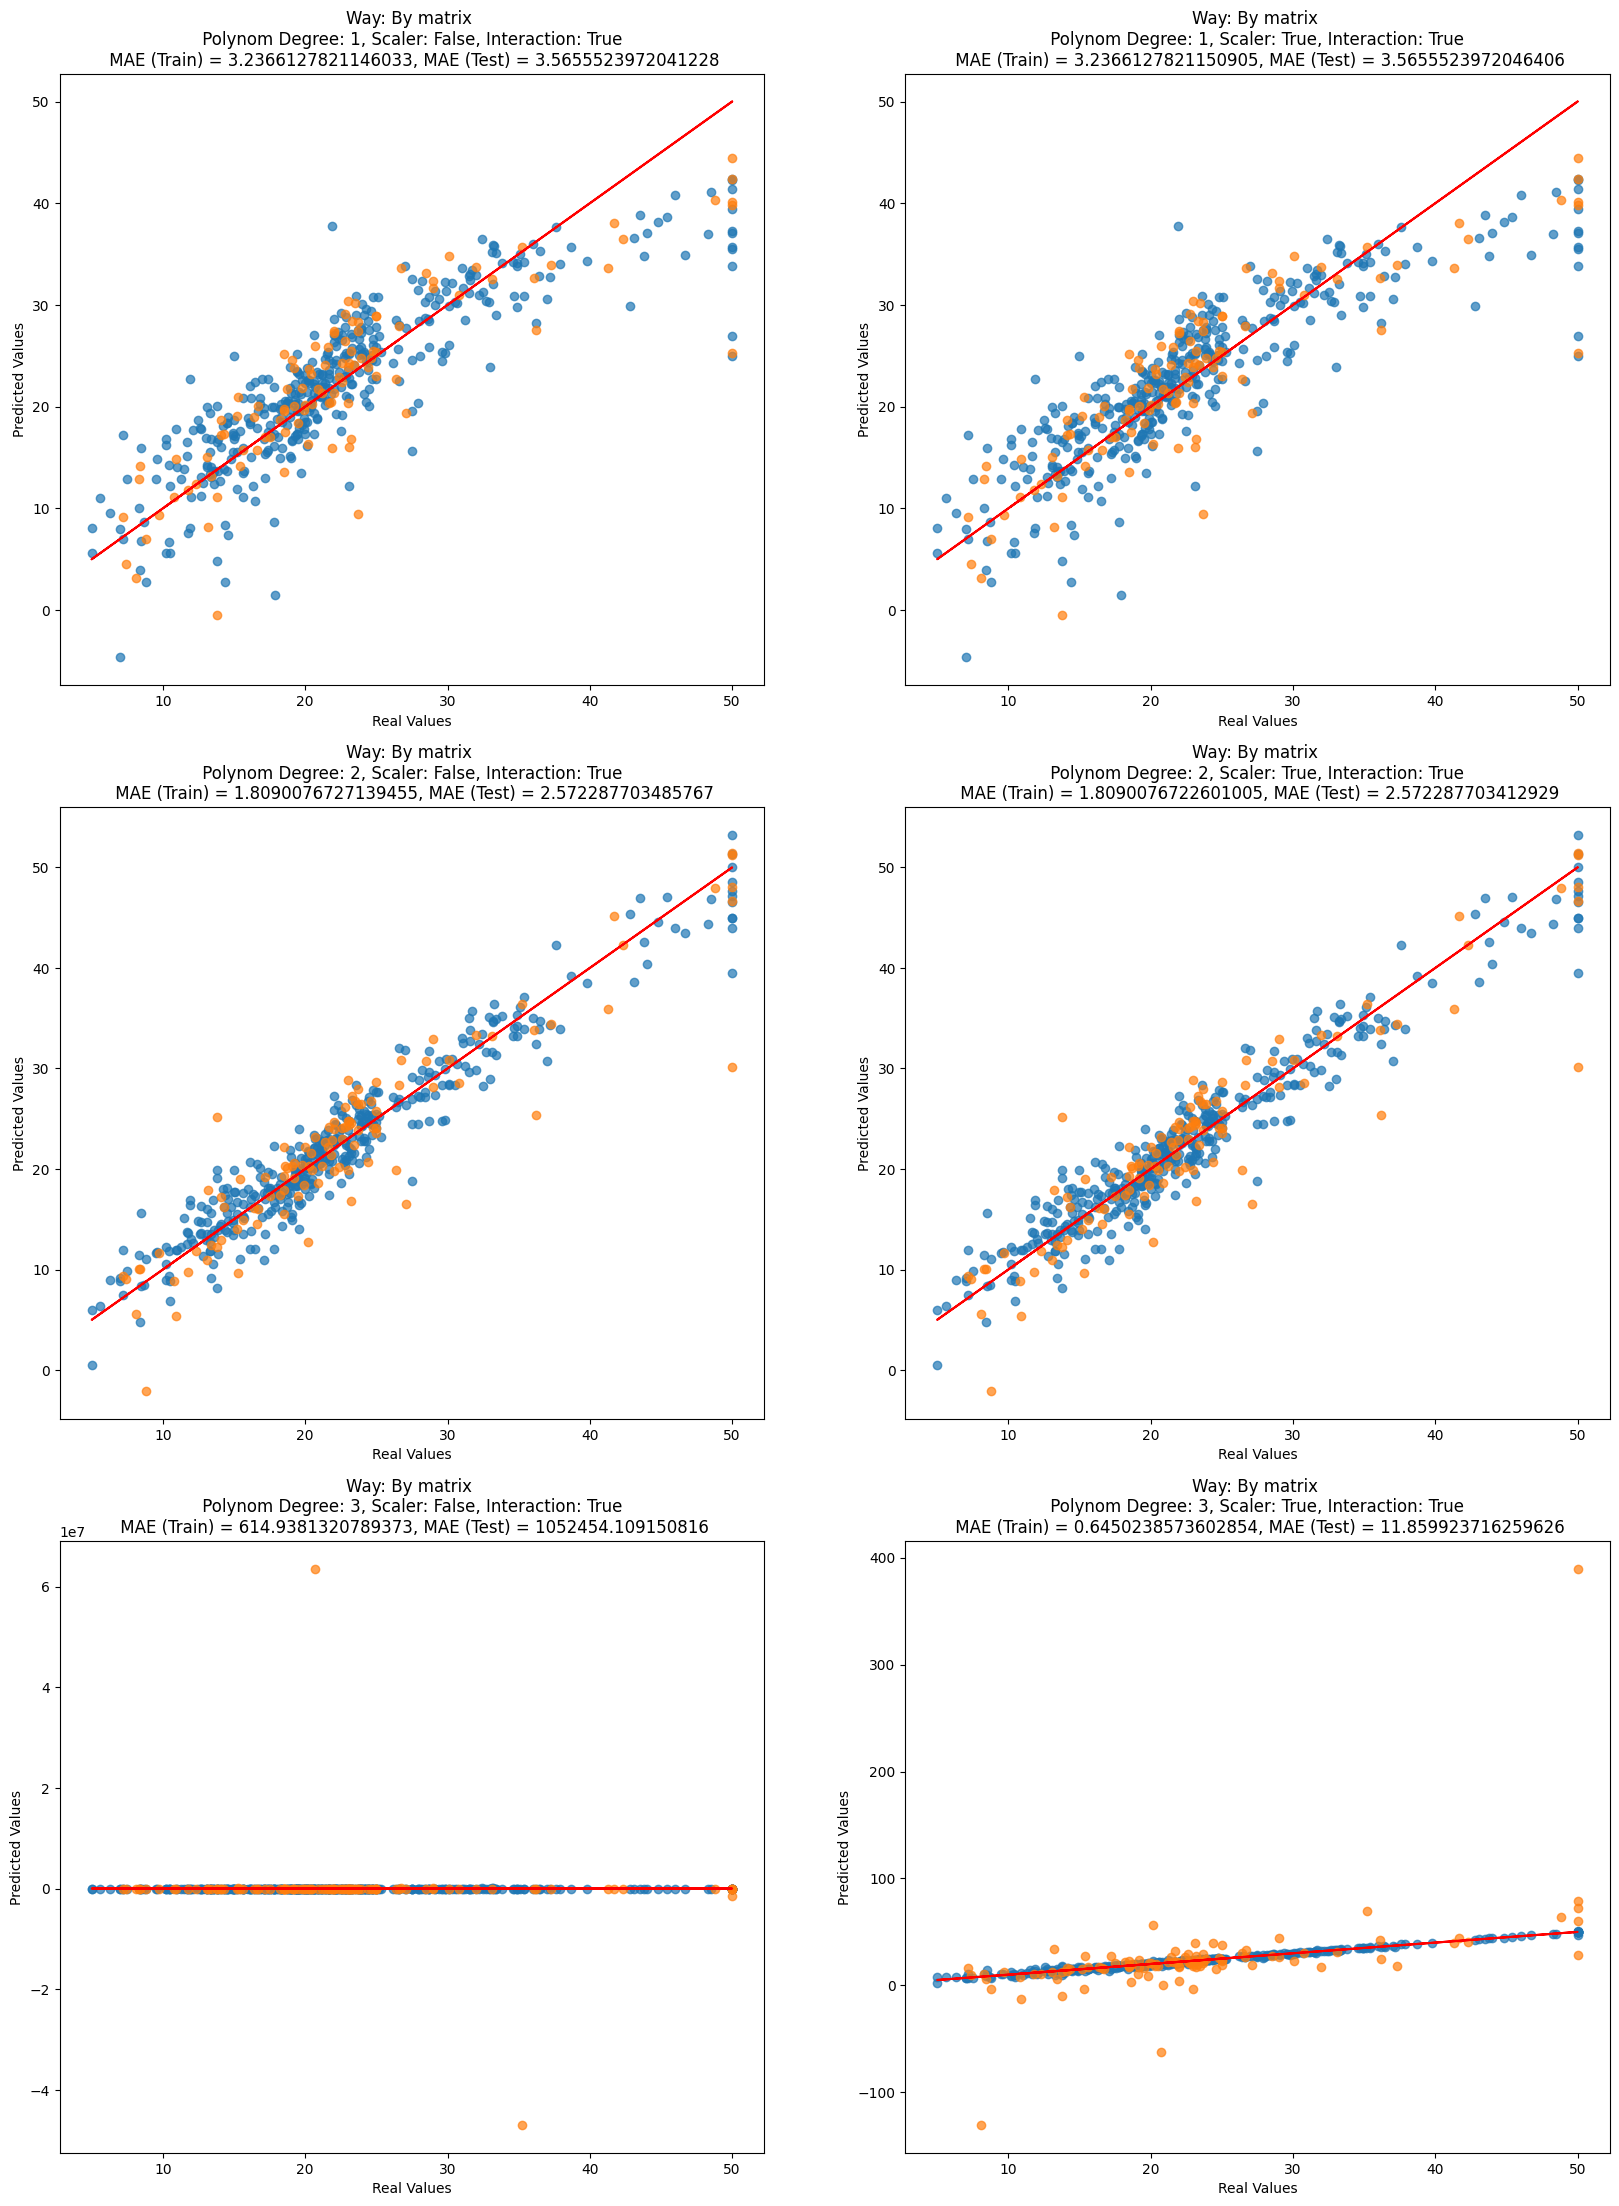

In [37]:
table_by_hand = report(3, all=True, by_hand=True, draw=True)

In [38]:
table_by_hand = report(3, all=True, by_hand=True, draw=False)
table_by_hand

,Scaler,Degree,MAE Train,MAE Test,Condition Number
0,False,1,3.237,3.566,2.109547e+08
1,True,1,3.237,3.566,2.109547e+08
2,False,2,1.809,2.572,1.517786e+16
3,True,2,1.809,2.572,1.517786e+16
4,False,3,614.938,1052454.109,4.691288e+30
5,True,3,0.645,11.860,4.691288e+30


<Figure size 2000x2700 with 0 Axes>

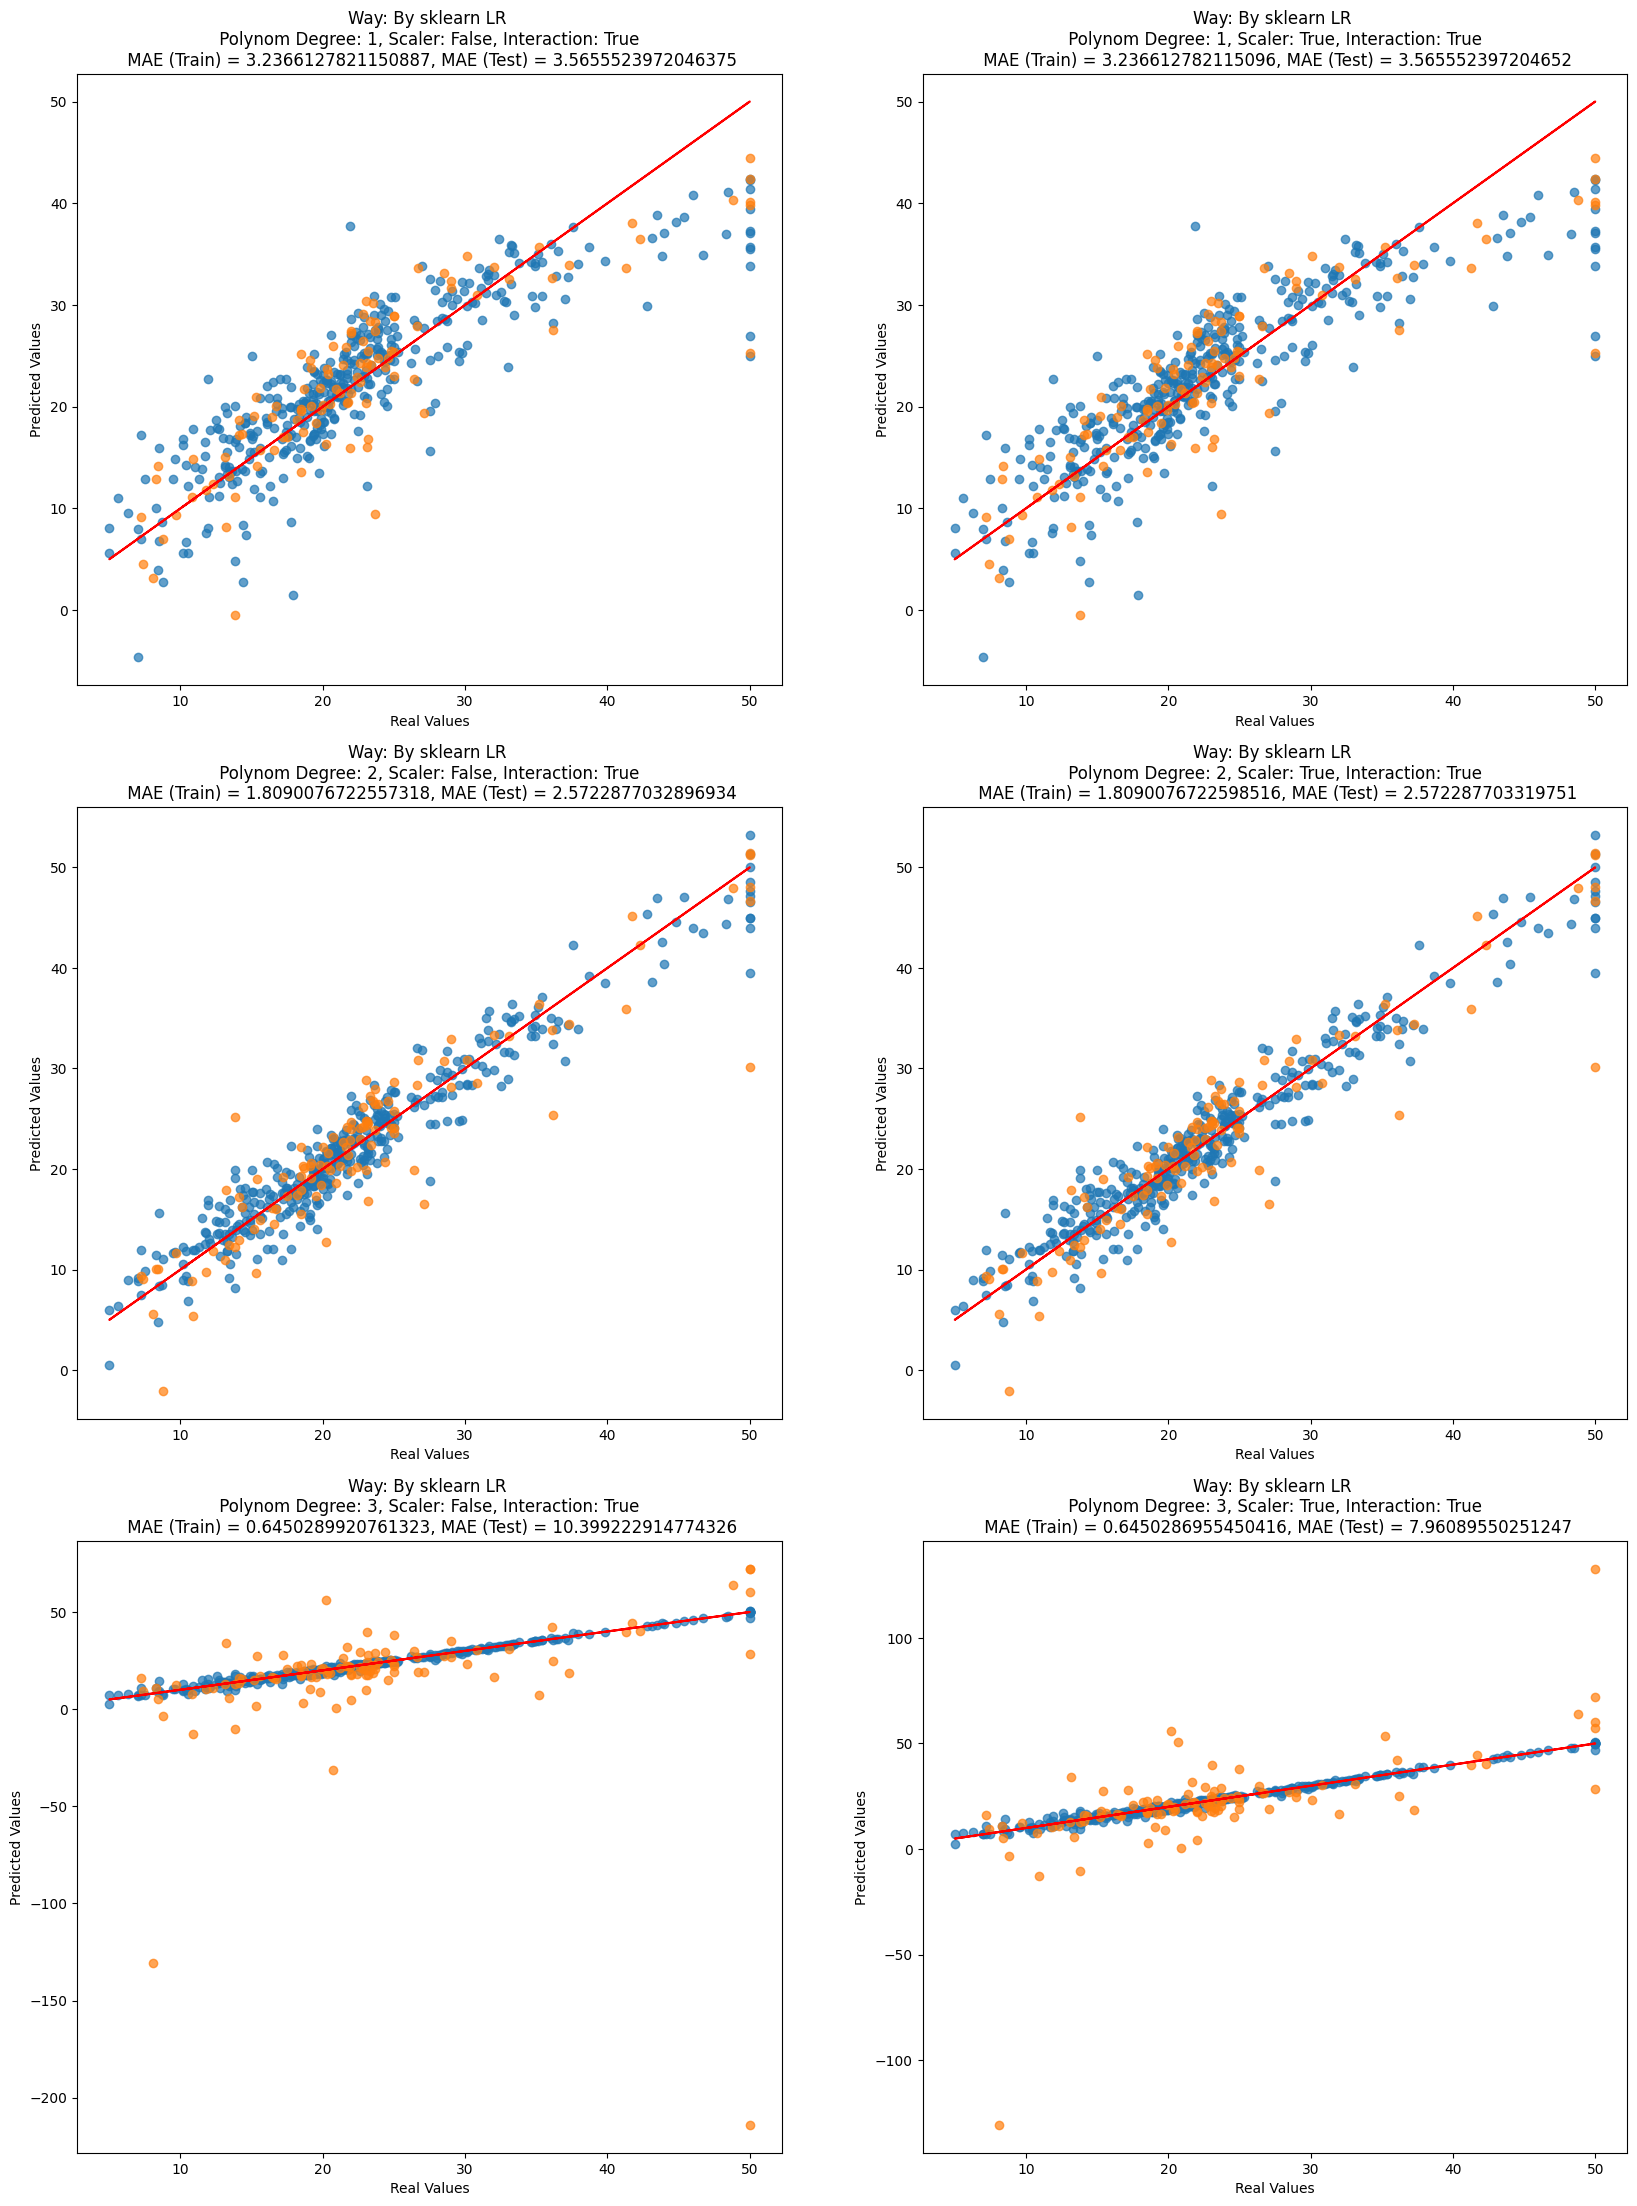

In [39]:
table_by_robot = report(3, all=True, by_hand=False, draw=True)

In [40]:
table_by_robot = report(3, all=True, by_hand=False, draw=False)
table_by_robot

,Scaler,Degree,MAE Train,MAE Test
0,False,1,3.237,3.566
1,True,1,3.237,3.566
2,False,2,1.809,2.572
3,True,2,1.809,2.572
4,False,3,0.645,10.399
5,True,3,0.645,7.961


<Figure size 2000x2700 with 0 Axes>